# 用于角点检测的FAST算法

### 目标

在本章中，
- 我们将了解FAST算法的基础知识。
- 我们将使用OpenCV功能对FAST算法进行探索。

### 理论

我们看到了几个特征检测器，其中很多真的很棒。但是，从实时应用程序的角度来看，它们不够快。最好的例子是计算资源有限的SLAM（同时定位和制图）移动机器人

作为对此的解决方案，Edward Rosten和Tom Drummond在2006年的论文“用于高速拐角检测的机器学习”中提出了FAST（加速分段测试的特征）算法（后来在2010年对其进行了修订）。该算法的基本内容如下。有关更多详细信息，请参阅原始论文（所有图像均取自原始论文）。

### 使用FAST进行特征检测

1. 选择图像中是否要识别为兴趣点的像素$p$，使其强度为$I_p$
2. 选择适当的阈值$t$
3. 考虑被测像素周围有16个像素的圆圈。（见下图） 
![](data/fast_speedtest.jpg)

4. 现在，如果圆中存在一组（共16个像素）$n$个连续的像素，它们均比$I_p + t$亮，或者比$I_p-t$都暗，则像素$p$是一个角。（在上图中显示为白色虚线）。n被选为12。

5. 建议使用高速测试以排除大量的非角区域。此测试仅检查1、9、5和13处的四个像素（如果第一个1和9太亮或太暗，则对其进行测试。如果是，则检查5和13）。如果p是一个角，则其中至少三个必须全部比$I_p + t$亮或比$I_p-t$暗。如果以上两种情况都不是，则$p$不能为角。然后，可以通过检查圆中的所有像素，将完整的分段测试标准应用于通过的候选项。该检测器本身具有很高的性能，但有几个缺点：
   - 它不会拒绝n <12的候选对象。
   - 像素的选择不是最佳的，因为其效率取决于问题的顺序和角落外观的分布。
   - 高速测试的结果被丢弃了。
   - 彼此相邻地检测到多个特征。

机器学习的方法解决了前三点。使用非最大抑制来解决最后一个问题。

### 让机器学习一个角检测器

1. 选择一组图像进行训练（最好从目标应用程序域中进行训练）
2. 在每个图像中运行FAST算法以查找特征点。
3. 对于每个特征点，将其周围的16个像素存储为矢量。对所有图像执行此操作以获得特征向量P。
4. 这16个像素中的每个像素（例如$x$）可以具有以下三种状态之一： 

![](data/fast_eqns.jpg)

5. 取决于这些状态，特征矢量$P$被细分为3个子集，$P_d$, $P_s$, $P_b$。

6. 定义一个新的布尔变量$K_p$，如果$p$是一个角，则为true，否则为false。

7. 使用ID3算法（决策树分类器）使用变量$K_p$查询每个子集，以获取有关真实类的知识。它选择x，该x通过$K_p$的熵测得的有关候选像素是否为角的信息最多。
8. 递归地将其应用于所有子集，直到其熵为零为止。
9. 这样创建的决策树用于其他图像的快速检测。

#### 非最大抑制

在相邻位置检测多个兴趣点是另一个问题。通过使用非极大抑制来解决。

1. 计算所有检测到的特征点的得分函数$V$。$V$是$p$与16个周围像素值之间的绝对差之和。
2. 考虑两个相邻的关键点并计算它们的$V$值。
3. 丢弃较低$V$值的那个。

#### 总结

它比其他现有的拐角检测器快几倍。

但是它对高水平的噪声并不鲁棒。它取决于阈值。

### OpenCV中的高速拐角检测器

它被称为OpenCV中的任何其他特征检测器。
如果需要，您可以指定阈值，是否要应用非极大抑制，要使用的邻域等。
对于邻域，定义了三个标志，分别为`cv.FAST_FEATURE_DETECTOR_TYPE_5_8`，`cv.FAST_FEATURE_DETECTOR_TYPE_7_12`和`cv.FAST_FEATURE_DETECTOR_TYPE_9_16`。
以下是有关如何检测和绘制FAST特征点的简单代码。

Threshold: 10
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 431
Total Keypoints without nonmaxSuppression: 1575


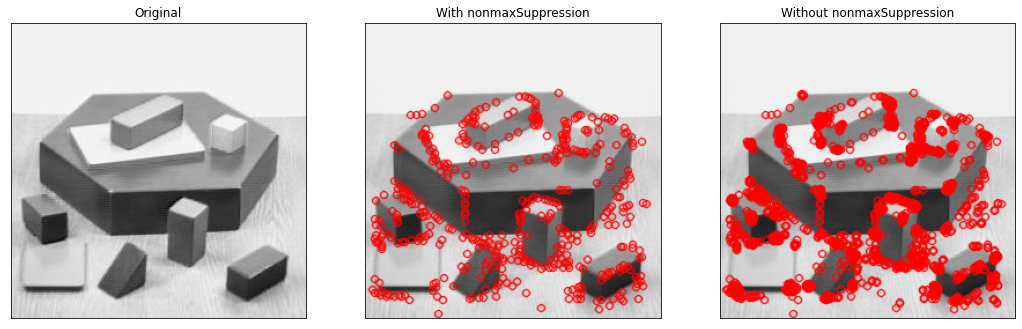

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/blox.jpg',0)

# 用默认值初始化FAST对象
fast = cv.FastFeatureDetector_create()

# 寻找并绘制关键点
kp = fast.detect(img,None)
img2 = cv.drawKeypoints(img, kp, None, color=(255,0,0))

# 打印所有默认参数
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
cv.imwrite('output/fast_true.png',img2)

# 关闭非极大抑制
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)
print( "Total Keypoints without nonmaxSuppression: {}".format(len(kp)) )

img3 = cv.drawKeypoints(img, kp, None, color=(255,0,0))
cv.imwrite('output/fast_false.png',img3)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1),plt.imshow(img, 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img2, 'gray')
plt.title('With nonmaxSuppression')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img3, 'gray')
plt.title('Without nonmaxSuppression')
plt.xticks([]), plt.yticks([])
plt.show()

查看结果。第一张图片显示了带有nonmaxSuppression的FAST，第二张图片显示了没有nonmaxSuppression的FAST：

### 附加资源

1. Edward Rosten and Tom Drummond, “Machine learning for high speed corner detection” in 9th European Conference on Computer Vision, vol. 1, 2006, pp. 430–443.
2. Edward Rosten, Reid Porter, and Tom Drummond, "Faster and better: a machine learning approach to corner detection" in IEEE Trans. Pattern Analysis and Machine Intelligence, 2010, vol 32, pp. 105-119.

### 练习